In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# pip install shap

In [3]:
import os

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader,TensorDataset
import torch.nn.functional as F
# from torch.autograd import Variable
import torchvision.models as models  

import warnings# 移除不必要的警告
warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from xgboost import plot_importance
# import shap

In [4]:
import matplotlib as mpl
zhfont = mpl.font_manager.FontProperties(fname='/content/drive/MyDrive/chinese.simhei.ttf')#取得中文字型

sns.set(font=zhfont.get_name())


In [27]:
df = pd.read_csv('/content/drive/MyDrive/preprocess(1).csv')

df.set_index(keys =df.columns[0],inplace=True)
df['y_class']=(df.y)>1
df.head()

,"('多方交易口數', '合計 ')","('多方交易口數', '外資 ')","('多方交易口數', '投信 ')","('多方交易口數', '自營商 ')","('多方交易契約金額', '合計 ')","('多方交易契約金額', '外資 ')","('多方交易契約金額', '投信 ')","('多方交易契約金額', '自營商 ')","('多方未平倉口數', '合計 ')","('多方未平倉口數', '外資 ')","('多方未平倉口數', '投信 ')","('多方未平倉口數', '自營商 ')","('多方未平倉契約金額', '合計 ')","('多方未平倉契約金額', '外資 ')","('多方未平倉契約金額', '投信 ')","('多方未平倉契約金額', '自營商 ')","('多空交易口數淨額', '合計 ')","('多空交易口數淨額', '外資 ')","('多空交易口數淨額', '投信 ')","('多空交易口數淨額', '自營商 ')","('多空交易契約金額淨額', '合計 ')","('多空交易契約金額淨額', '外資 ')","('多空交易契約金額淨額', '投信 ')","('多空交易契約金額淨額', '自營商 ')","('多空未平倉口數淨額', '合計 ')","('多空未平倉口數淨額', '外資 ')","('多空未平倉口數淨額', '投信 ')","('多空未平倉口數淨額', '自營商 ')","('多空未平倉契約淨額', '合計 ')","('多空未平倉契約淨額', '外資 ')","('多空未平倉契約淨額', '投信 ')","('多空未平倉契約淨額', '自營商 ')","('空方交易口數', '合計 ')","('空方交易口數', '外資 ')","('空方交易口數', '投信 ')","('空方交易口數', '自營商 ')","('空方交易契約金額', '合計 ')","('空方交易契約金額', '外資 ')","('空方交易契約金額', '投信 ')","('空方交易契約金額', '自營商 ')",...,"('成交量(千股)', '紡纖 ')_div","('成交量(千股)', '紡纖 ')_div(%)","('成交量(千股)', '造紙類 ')_div","('成交量(千股)', '造紙類 ')_div(%)","('成交量(千股)', '金融類 ')_div","('成交量(千股)', '金融類 ')_div(%)","('成交量(千股)', '食品類 ')_div","('成交量(千股)', '食品類 ')_div(%)","('收盤價', '#DX')_ret","('收盤價', '#GSPC')_ret","('收盤價', '#IXIC')_ret","('收盤價', '#IXID')_ret","('收盤價', '#IXK')_ret","('收盤價', '#NDX')_ret","('收盤價', '#S5CD')_ret","('收盤價', '#S5CS')_ret","('收盤價', '#S5INDU')_ret","('收盤價', '#S5INFO')_ret","('收盤價', '#SOXX')_ret","('收盤價', '#VIX')_ret","('收盤價', '#VXN')_ret",收盤價(元)_x_ret,收盤價(元)_y_ret,"('收盤價(元)', 'TR未金電 ')_ret","('收盤價(元)', '不含金融 ')_ret","('收盤價(元)', '不含電子 ')_ret","('收盤價(元)', '不含電子報酬 ')_ret","('收盤價(元)', '加權指數 ')_ret","('收盤價(元)', '報酬指數 ')_ret","('收盤價(元)', '塑膠化工 ')_ret","('收盤價(元)', '未含金電 ')_ret","('收盤價(元)', '機電類 ')_ret","('收盤價(元)', '水泥窯業 ')_ret","('收盤價(元)', '營建 ')_ret","('收盤價(元)', '紡纖 ')_ret","('收盤價(元)', '造紙類 ')_ret","('收盤價(元)', '金融類 ')_ret","('收盤價(元)', '食品類 ')_ret",y,y_class
年月日,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2007-07-03,395169,22221,792,372156,31680000,7965000,1058000,22657000,592294,246553,1021,344720,94717000,40824000,1152000,52741000,4332,-2854,-483,7669,9437000,-848000,919000,9366000,-152605,-5762,-10747,-136096,9073000,-18678000,-10345000,38096000,390837,25075,1275,364487,22243000,8813000,139000,13291000,...,72685.0,0.438742,-17422.0,-0.291080,201916.0,0.569720,39272.0,0.379932,0.000614,0.003580,0.004806,0.001489,0.008824,0.005670,-0.000096,0.000071,0.003324,0.007358,0.000198,-0.007143,-0.017647,0.002815,0.009848,0.009797,0.005901,0.006356,0.009656,0.006344,0.007783,-0.002419,0.005062,0.006732,-0.001782,0.005712,0.014492,0.000207,0.009080,0.030225,0.008198,False
2007-07-04,516232,47360,327,468545,44422000,14649000,375000,29398000,641980,256255,971,384754,105854000,44978000,1146000,59730000,-1182,5235,-12,-6405,2034000,-4388000,291000,6131000,-153798,-527,-10776,-142495,11205000,-22724000,-10180000,44109000,517414,42125,339,474950,42388000,19037000,84000,23267000,...,230061.0,0.965215,21335.0,0.502816,16821.0,0.030236,-1095.0,-0.007677,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.009832,0.000000,0.011282,0.008481,0.009355,0.009593,0.008090,0.008198,0.008349,0.011106,0.007285,0.006287,0.036535,0.025500,0.011270,0.005686,0.017756,0.009611,False
2007-07-05,340678,25268,709,314701,23970000,6345000,496000,17129000,664970,265112,893,398965,110191000,46534000,1103000,62554000,19741,1124,67,18550,-689000,-3278000,118000,2471000,-134201,597,-10709,-124089,10649000,-25718000,-10142000,46509000,320937,24144,642,296151,24659000,9623000,378000,14658000,...,-53324.0,-0.113840,-16402.0,-0.257222,-84249.0,-0.146993,-11431.0,-0.080760,0.001228,0.000348,0.004424,0.003026,0.008065,0.008070,0.006559,-0.000962,-0.000251,0.007025,0.007616,0.012426,0.023353,-0.006954,0.000000,0.005634,0.009387,0.005130,0.006854,0.008799,0.009611,0.008598,0.005116,0.011422,-0.013147,0.003397,0.031191,-0.005317,0.005150,0.006243,0.004402,False
2007-07-06,330124,16264,245,313615,30868000,8393000,269000,22206000,672632,

In [28]:
df.index=pd.to_datetime(df.index,format="%Y/%m/%d")
df.index.name='date'
feature=df.columns[:-2]
print(len(feature))

feature_len=len(feature)

221


## **`以過去20天預測第21天股價`**

In [29]:
DAYS_FOR_TRAIN=20
def deal_lstm(df,feature,n = DAYS_FOR_TRAIN):#以20天作為預測
    
    X = []
    y = []
    dataset_scaled_x = df[feature]
    
    for i in range(0, len(df)-n):
        X.append(dataset_scaled_x[i:i+n])
        y.append(df['y'].iloc[i+n-1])
    
    return (np.array(X),np.array(y))

## 標準化(`MinMaxScaler`)

In [30]:
def tol_normalize(ddf):

  for col in feature:
    ddf[col]=MinMaxScaler().fit_transform(ddf[col].values.reshape(-1, 1))

  # ddf=MinMaxScaler().fit_transform(ddf)
  return ddf

**Feature** **select(以xgboost 挑選最重要20特徵)**

[07:30:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


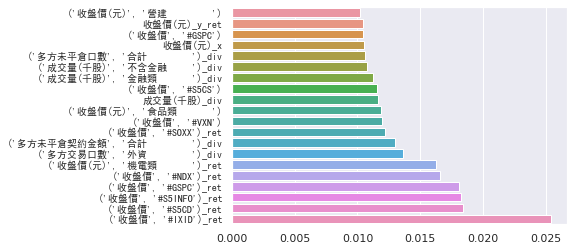

In [31]:
xgb = XGBRegressor(n_estimators=100)
xgb.fit(df[:'2013'][feature], df[:'2013']['y'])
sorted_idx = xgb.feature_importances_.argsort()
# plot_importance(xgb, max_num_features = 20)#xgb內建畫圖，但比較不漂亮
sns.set(font=zhfont.get_name())
plt.yticks(fontproperties=zhfont)

sns.barplot(xgb.feature_importances_[sorted_idx][-20::],feature[sorted_idx][-20::] )

feature_new=feature[sorted_idx][-20::]

In [32]:
#shap解釋重要特徵(有亂碼)
# explainer = shap.TreeExplainer(xgb)
# shap_values = explainer.shap_values(df[:'2013'][feature])
# shap.summary_plot(shap_values, df[:'2013'][feature], plot_type="bar")

In [33]:
train_x,train_y=deal_lstm(tol_normalize(df[:'2013']),feature_new)
valid_x,valid_y=deal_lstm((df['2013':'2017']),feature_new)
test_x,test_y=deal_lstm((df['2017':]),feature_new)

In [34]:
print(train_x.shape)
print(train_y.shape)


(1594, 20, 20)
(1594,)


In [35]:
class ElecDataset(Dataset):
    def __init__(self,feature,target):
        self.feature = feature
        self.target = target
    
    def __len__(self):
        return len(self.feature)
    
    def __getitem__(self,idx):
        item = self.feature[idx]
        label = self.target[idx]
        
        return item,label

In [36]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=30, num_layers=1, output_dim=1):
      super(LSTM, self).__init__()
      # Hidden dimensions
      self.hidden_dim = hidden_dim    

      # Number of hidden layers
      self.num_layers = num_layers

      self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)

      self.fc = nn.Linear(hidden_dim, output_dim) 

    def forward(self, x):
      # Initialize hidden state with zeros
      h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

      # Initialize cell state
      c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_().to(device)

      # One time step
      # If we don't, we'll backprop all the way to the start even after going through another batch
      out, (hn, cn) = self.lstm(x)

      out = out.to(device)
      #print('b',out.shape)
      #print(type(out))

      # Index hidden state of last time step
      # out[:, -1, :] --> 100, 100 --> just want last time step hidden states! 
      out = self.fc(out[:, -1, :]) 
      # out.size() --> 100, 10
      return out     

In [49]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()

        self.conv = nn.Sequential(
            nn.Conv1d(20,20,kernel_size=1,stride=2),# in,out,k
            nn.SELU(20),
            # nn.Dropout(),
            # nn.MaxPool2d(2, stride=2),
            )
        
  
        self.fc_model = nn.Sequential(
            nn.Linear(20*10,50),		
            nn.BatchNorm1d(50,track_running_stats=False),
            nn.SELU(50),
            nn.Dropout(),
            nn.Linear(50,50),		
            nn.BatchNorm1d(50),
            nn.SELU(50),
            # nn.Dropout(),
            # nn.Linear(50,30),		
            # nn.BatchNorm1d(30),
            # nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50,50))#5為輸出幾類

        self.lstm = LSTM(50) 
        '''
        #
        Input: W Filter: K Padding: P Stride: S Output: (W –K + 2P) / S + 1
        '''
        
    def forward(self,x):

        x = self.conv(x)
        x = x.view(x.size(0), -1)
        out = self.fc_model(x)
        out = self.lstm(out.unsqueeze(0)) 

        return out

In [50]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)
model = model.double()


optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1, last_epoch=-1) #gamma=0.1)
# scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.9) #gamma=0.1)

criterion = nn.MSELoss()
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv1d(20, 20, kernel_size=(1,), stride=(2,))
    (1): SELU(inplace=True)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=200, out_features=50, bias=True)
    (1): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): SELU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=50, out_features=50, bias=True)
    (5): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): SELU(inplace=True)
    (7): Dropout(p=0.5, inplace=False)
    (8): Linear(in_features=50, out_features=50, bias=True)
  )
  (lstm): LSTM(
    (lstm): LSTM(50, 30, batch_first=True)
    (fc): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [51]:
print((train_x.reshape(train_x.shape[0],-1,train_x.shape[1])).shape)

(1594, 20, 20)


In [52]:
train = ElecDataset(train_x.reshape(train_x.shape[0],-1,train_x.shape[1]),train_y)
valid = ElecDataset(valid_x.reshape(valid_x.shape[0],-1,valid_x.shape[1]),valid_y)
test = ElecDataset(test_x.reshape(test_x.shape[0],-1,test_x.shape[1]),test_y)

train_loader = torch.utils.data.DataLoader(train,batch_size=128,shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid,batch_size=128,shuffle=False)
test_loader = torch.utils.data.DataLoader(test,batch_size=128,shuffle=False)

In [53]:
train_losses = []
valid_losses = []
def Train():
    
    running_loss = .0
    
    model.train()
    
    for idx, (inputs,labels) in enumerate(train_loader):
        inputs = inputs.cuda()
        labels = labels.cuda()
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds,labels)
        torch.nn.utils.clip_grad_norm_(model.parameters(),1)

        loss.backward()
        optimizer.step()
        # scheduler.step()
        running_loss += loss
        
    train_loss = running_loss/len(train_loader)
    train_losses.append(train_loss.detach().cpu().numpy())
    
    print(f'train_loss {train_loss}')

In [54]:
def Valid():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss
            
        valid_loss = running_loss/len(valid_loader)
        valid_losses.append(valid_loss.detach().cpu().numpy())
        print(f'valid_loss {valid_loss}')

In [55]:
epochs =450
for epoch in range(epochs):
    print('epochs {}/{}'.format(epoch+1,epochs))
    Train()
    Valid()
    # gc.collect()

epochs 1/450
train_loss 0.055411337985568056
valid_loss 0.015681707952822855
epochs 2/450
train_loss 0.03283838309952828
valid_loss 0.013666641325329252
epochs 3/450
train_loss 0.013021692116378561
valid_loss 0.0014963542477338181
epochs 4/450
train_loss 0.014603695036249373
valid_loss 0.0027142913464800506
epochs 5/450
train_loss 0.007627706525172708
valid_loss 0.003306778231652389
epochs 6/450
train_loss 0.005437492492731121
valid_loss 0.004221517157634049
epochs 7/450
train_loss 0.0030249627222981228
valid_loss 0.0008643400942070062
epochs 8/450
train_loss 0.001482415958325794
valid_loss 0.0007340961548749232
epochs 9/450
train_loss 0.0007125251356204462
valid_loss 0.0009644937734481172
epochs 10/450
train_loss 0.0005160581117610213
valid_loss 0.0005212375125875226
epochs 11/450
train_loss 0.0005197623149254804
valid_loss 0.0007734028542983541
epochs 12/450
train_loss 0.0002759860868272096
valid_loss 0.0007651700149118561
epochs 13/450
train_loss 0.00042658093023455516
valid_loss 0.

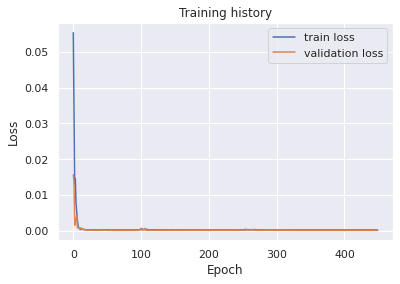

In [56]:
# plt.figure(figsize=(25,10))

plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
# plt.ylim([0, 0.001]);

In [57]:
test_losses=[]
real_test =[]
predict_test = []
def test():
    running_loss = .0
    
    model.eval()
    
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            preds = model(inputs)
            loss = criterion(preds,labels)
            running_loss += loss
            real_test.extend(labels.to('cpu').numpy().tolist())
            predict_test.extend(preds.to('cpu').numpy().tolist())
        test_loss = running_loss/len(test_loader)
        test_losses.append(test_loss.detach().cpu().numpy())
        
        return print(f'test_loss {test_loss}')

In [58]:
test()

test_loss 0.0001051586722075397


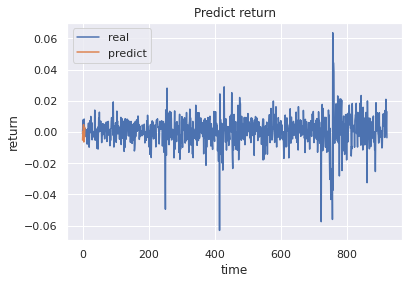

In [59]:
plt.title('Predict return')

plt.plot(real_test, label='real')
plt.plot(predict_test, label='predict')
plt.ylabel('return')
plt.xlabel('time')
plt.legend()